In [1]:
import importlib
import warnings
from logging import getLogger
from types import ModuleType
from process_bigraph import ProcessTypes
from bigraph_schema.protocols import function_module
from unum import Unum
from importlib import import_module
from typing import *

from wholecell.utils import units
from ecoli.experiments.ecoli_master_sim import EcoliSim
from ecoli.shared import ecoli_core as ec
from ecoli.shared.types.register import test_register_type
from ecoli.instances.base import vivarium_base as v

In [9]:
sim = EcoliSim.from_file('/Users/alexanderpatrie/Desktop/repos/ecoli/v2Ecoli/ecoli/composites/ecoli_configs/test_configs/cell_wall_division.json')

In [21]:
sim.topology
sim.flow
sim.processes

{'RNA_counts_listener': None,
 'bulk-timeline': None,
 'death_threshold': None,
 'dna_supercoiling_listener': None,
 'ecoli-chromosome-replication': None,
 'ecoli-chromosome-structure': None,
 'ecoli-complexation': None,
 'ecoli-equilibrium': None,
 'ecoli-mass-listener': None,
 'ecoli-metabolism': None,
 'ecoli-polypeptide-elongation': None,
 'ecoli-polypeptide-initiation': None,
 'ecoli-protein-degradation': None,
 'ecoli-rna-degradation': None,
 'ecoli-rna-maturation': None,
 'ecoli-tf-binding': None,
 'ecoli-tf-unbinding': None,
 'ecoli-transcript-elongation': None,
 'ecoli-transcript-initiation': None,
 'ecoli-two-component-system': None,
 'exchange_data': None,
 'global_clock': None,
 'media_update': None,
 'monomer_counts_listener': None,
 'post-division-mass-listener': None,
 'replication_data_listener': None,
 'ribosome_data_listener': None,
 'rna_synth_prob_listener': None,
 'rnap_data_listener': None,
 'unique_molecule_counts': None}

In [23]:
# flow represents which processes should be connected
# topology represents the overall ports for the composite(emitter?)
# processes represents the actual processes involved.

# THUS, to create the composite doc we should:
# 1. For each key(process) in sim.processes, create the composite doc as usual:
# 1a. 


def construct_state(sim: EcoliSim):
    sim_processes = sim.processes
    state = {}
    for process_id in sim_processes:
        state[process_id] = {
            "address": f"local:{process_id}",
            "config": sim.process_configs.get(process_id),
            "inputs": {}
        }


In [20]:
sim.process_configs

{'global_clock': {},
 'replication_data_listener': {'time_step': 1},
 'ecoli-cell-wall': {},
 'ecoli-pbp-binding': {},
 'ecoli-shape': {},
 'ecoli-metabolism': {'reduce_murein_objective': True},
 'murein-division': {}}

In [22]:
dir(sim)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_retrieve_process_configs',
 '_retrieve_processes',
 '_retrieve_topology',
 'add_processes',
 'agent_id',
 'amp_lysis',
 'build_ecoli',
 'chromosome_path',
 'condition',
 'config',
 'd_period',
 'daughter_outdir',
 'description',
 'divide',
 'division_threshold',
 'division_variable',
 'ecoli',
 'ecoli_experiment',
 'emit_config',
 'emit_paths',
 'emit_processes',
 'emit_topology',
 'emit_unique',
 'emitter',
 'emitter_arg',
 'engine_process_reports',
 'exclude_processes',
 'experiment_id',
 'experiment_id_base',
 'export_json',
 'fail_at_total_time',
 'fixed_media',
 'flow',
 'from_cli',
 'from_file',
 

In [3]:
from vivarium import Vivarium

v = Vivarium(core=ec, processes=ec.process_registry.registry, types=ec.types())

In [5]:
import numpy as np 


doc = {
    'complexation': {
        '_type': 'process',
        'address': 'local:complexation',
        'config': {
            "stoichiometry": [[-1, 1, 0], [0, -1, 1], [1, 0, -1], [-1, 0, 1], [1, -1, 0], [0, 1, -1]],
            "rates": np.random.random((6,)).tolist(),
            "molecule_names": ["A", "B", "C"],
            "seed": 1,
            "reaction_ids": [1, 2, 3, 4, 5, 6],
            "complex_ids": [1, 2, 3, 4, 5, 6],
        },
        'inputs': {
            'bulk': ['bulk'],
            'timestep': ['timestep']
        }

,Process
0,json-emitter
1,parquet-emitter
2,two_component_system
3,toyode
4,rna_interference
5,tf_binding
6,divide
7,chemostat
8,bulk_timeline
9,global_clock


In [8]:
dir(v)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_read_emitter_config',
 'add_emitter',
 'add_object',
 'add_process',
 'composite',
 'connect_process',
 'core',
 'diagram',
 'emitter_config',
 'find_package',
 'generate',
 'generate_composite_from_document',
 'get_dataclass',
 'get_processes',
 'get_results',
 'get_schema',
 'get_state',
 'get_timeseries',
 'get_type',
 'get_types',
 'get_value',
 'make_document',
 'plot_timeseries',
 'print_processes',
 'print_types',
 'process_interface',
 'process_schema',
 'register_processes',
 'register_types',
 'reset_emitters',
 'reset_paths',
 'run',
 'save',
 'set_value',
 'step']

In [9]:
v.process_schema('grow')

'(rate:float)'

In [10]:
from process_bigraph.processes import TOY_PROCESSES

In [11]:
g = TOY_PROCESSES.get("grow")(core=ec)

In [12]:
g.inputs(), g.outputs()

({'mass': 'float'}, {'mass': 'float'})

In [13]:
schema = {'mass': ['mass']}
v.add_process('grow', 'grow', config={'rate': 0.22}, inputs=schema, outputs=schema)

In [14]:
v

Vivarium( 
{ 'global_time': 0.0,
  'grow': { 'address': 'local:grow',
            'config': {'rate': 0.22},
            'inputs': {'mass': ['mass']},
            'instance': <process_bigraph.processes.growth_division.Grow object at 0x176f537a0>,
            'interval': 1.0,
            'outputs': {'mass': ['mass']},
            'shared': None},
  'mass': 0.0})

In [15]:
v.add_emitter()

In [16]:
v

Vivarium( 
{ 'emitter': { 'address': 'local:parquet-emitter',
               'config': { 'batch_size': 400,
                           'emit': {'global_time': 'any', 'mass': 'any'},
                           'experiment_id': None,
                           'out_dir': '/Users/alexanderpatrie/Desktop/repos/v2Ecoli/storage/data',
                           'out_uri': None},
               'inputs': {'global_time': ['global_time'], 'mass': ['mass']},
               'instance': <ecoli.emitters.parquet.ParquetEmitter object at 0x13263d280>,
               'outputs': None},
  'global_time': 0.0,
  'grow': { 'address': 'local:grow',
            'config': {'rate': 0.22},
            'inputs': {'mass': ['mass']},
            'instance': <process_bigraph.processes.growth_division.Grow object at 0x176f537a0>,
            'interval': 1.0,
            'outputs': {'mass': ['mass']},
            'shared': None},
  'mass': 0.0})

In [17]:
initial_state = {"mass": 11.11, "global_time": 22.2}
for obj, val in initial_state.items():
    v.set_value([obj], val)

In [18]:
v

Vivarium( 
{ 'emitter': { 'address': 'local:parquet-emitter',
               'config': { 'batch_size': 400,
                           'emit': {'global_time': 'any', 'mass': 'any'},
                           'experiment_id': None,
                           'out_dir': '/Users/alexanderpatrie/Desktop/repos/v2Ecoli/storage/data',
                           'out_uri': None},
               'inputs': {'global_time': ['global_time'], 'mass': ['mass']},
               'instance': <ecoli.emitters.parquet.ParquetEmitter object at 0x13263d280>,
               'outputs': None},
  'global_time': 22.2,
  'grow': { 'address': 'local:grow',
            'config': {'rate': 0.22},
            'inputs': {'mass': ['mass']},
            'instance': <process_bigraph.processes.growth_division.Grow object at 0x176f537a0>,
            'interval': 1.0,
            'outputs': {'mass': ['mass']},
            'shared': None},
  'mass': 11.11})

In [23]:
import numpy as np

duration = 1
timestep = 0.02
times = np.arange(0, duration, timestep).tolist()

In [25]:
for t in times:
    v.run(t)

In [26]:
v

Vivarium( 
{ 'emitter': { 'address': 'local:parquet-emitter',
               'config': { 'batch_size': 400,
                           'emit': {'global_time': 'any', 'mass': 'any'},
                           'experiment_id': None,
                           'out_dir': '/Users/alexanderpatrie/Desktop/repos/v2Ecoli/storage/data',
                           'out_uri': None},
               'inputs': {'global_time': ['global_time'], 'mass': ['mass']},
               'instance': <ecoli.emitters.parquet.ParquetEmitter object at 0x13263d280>,
               'outputs': None},
  'global_time': 46.699999999999996,
  'grow': { 'address': 'local:grow',
            'config': {'rate': 0.22},
            'inputs': {'mass': ['mass']},
            'instance': <process_bigraph.processes.growth_division.Grow object at 0x176f537a0>,
            'interval': 1.0,
            'outputs': {'mass': ['mass']},
            'shared': None},
  'mass': 1313.2578187216811})

In [39]:
from pyarrow import fs
from ecoli.emitters.parquet import format_out_dir
from tempfile import mkdtemp
import tempfile

temp = tempfile.NamedTemporaryFile(delete=False)
out_uri = format_out_dir(temp.name, 'test')
filesys, outdir = fs.FileSystem.from_uri(out_uri)

In [53]:
d = {'x': 11.11, 'y': 2.22}
import orjson

def write_parquet(data, outdir):
    with open(outdir, 'wb') as f:
        orjson.dump(data, f, option=orjson.OPT_SERIALIZE_NUMPY)

dir(filesys)


['__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__pyx_vtable__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '_from_uri',
 '_wrap_input_stream',
 '_wrap_output_stream',
 'copy_file',
 'create_dir',
 'delete_dir',
 'delete_dir_contents',
 'delete_file',
 'equals',
 'from_uri',
 'get_file_info',
 'move',
 'normalize_path',
 'open_append_stream',
 'open_input_file',
 'open_input_stream',
 'open_output_stream',
 'type_name']

In [45]:
with open(temp.name, 'rb') as f:
    d = f.read()

In [46]:
d

b'{"x":11.11,"y":2.22}'

In [48]:
type(temp)

tempfile._TemporaryFileWrapper

In [50]:
outdir

'/var/folders/yy/8crj8x7x5_3b86f0js6_0bn00000gr/T/tmpeax36z6r/test.dat'

In [1]:
import pickle 

simdata_path = "/Users/alexanderpatrie/Desktop/repos/v2Ecoli/reconstruction/sim_data/kb/simData.cPickle"
with open(simdata_path, 'rb') as f:
    content = pickle.load(f)

<unknown>:1: SyntaxWarning: invalid escape sequence '\s'


ImportError: cannot import name 'REVERSE_TAG' from partially initialized module 'reconstruction.ecoli.dataclasses.process.metabolism' (most likely due to a circular import) (/Users/alexanderpatrie/Desktop/repos/v2Ecoli/reconstruction/ecoli/dataclasses/process/metabolism.py)

In [6]:
import abc 
from process_bigraph import Step



class BaseEdge(object):
    topology = {} 


class A(Step):
    defaults = {}
    _name = ""
    def __init__(self, config, core):
        super().__init__(config, core)

    @property
    def name(self):
        return self._name

    @name.setter
    def name(self, v):
        self._name = v
    

In [8]:
A({}, ec).name

''

In [7]:
A.defaults, A.topology, A.name

({}, {}, <property at 0x16b419940>)

In [18]:
import abc
from dataclasses import dataclass, field

from process_bigraph import Step, Process
from vivarium.vivarium import Vivarium

from ecoli.shared.datamods import BaseClass
from ecoli.shared.schemas import get_config_schema
from ecoli.shared.registration import Core, ecoli_core



@dataclass 
class Topology(BaseClass):
    inputs: dict = field(default_factory=dict)
    outputs: dict = field(default_factory=dict)

    def __call__(self):
        return self.as_dict()


In [19]:
t = Topology()

In [20]:
t

Topology(inputs={}, outputs={})

In [24]:
dir(t)

['__annotations__',
 '__call__',
 '__class__',
 '__dataclass_fields__',
 '__dataclass_params__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__match_args__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_builtins',
 'as_bytes',
 'as_dict',
 'as_tuple',
 'get_attrs',
 'hydrate',
 'inputs',
 'outputs',
 'serialize']

In [30]:
class A(Step):
    def initial_state(self):
        return {'a': 11}

    def inputs(self):
        return {'x': 'integer'}

    def outputs(self):
        return {'a': 'integer'}

    def update(self, state):
        return {'a': state['x']**2}

ec.process_registry.register('A', A)

In [31]:
v = Vivarium(core=ec, processes={'A': A}, types=ec.types())

In [38]:
v.add_process('aprocess', 'A', inputs={'x': ['x']}, outputs={'a': ['a']})

TypeError: Vivarium.add_process() got an unexpected keyword argument 'shared'

In [34]:
v

Vivarium( 
{ 'a': 0,
  'aprocess': { 'address': 'local:A',
                'config': {},
                'inputs': {'x': ['x']},
                'instance': <__main__.A object at 0x1773f62a0>,
                'interval': 1.0,
                'outputs': {'a': ['a']},
                'shared': None},
  'global_time': 0.0,
  'x': 0})

In [35]:
v.add_emitter()

In [36]:
v.run(11)

In [43]:
doc = v.make_document()['state']['aprocess']

In [44]:
doc['shared'] = 

{'inputs': {'x': ['x']},
 'outputs': {'a': ['a']},
 'interval': 1.0,
 'address': 'local:A',
 'config': {},
 'shared': None}

In [45]:
x = [('a', 11), ('b', 22)]

for id, val in x:
    print(id)

a
b


In [54]:
from process_bigraph.processes import TOY_PROCESSES
from process_bigraph import Process
from ecoli import shared

grow = TOY_PROCESSES.get('grow')(config={'rate': 0.1122}, core=ec)

In [52]:
grow.interface()

{'inputs': {'mass': 'float'}, 'outputs': {'mass': 'float'}}

In [55]:
def get_type(value, type_mapping):
    type_name = type(value).__name__
    if type_name in type_mapping.keys():
        return type_mapping[type_name]
    else:
        return "any"  # TODO: a better way of defining a default type

    
def parse_schema(process: Process, type_mapping):
    """
    a. create initial_state from process.interface()
    b. 
    output_schema = process.interface().get('outputs', {})
    ports = process.ports_schema()
    initial_state = {}
    
    for k, v in ports.copy().items():
        if not isinstance(v, dict):
            type_name = type(v).__name__
            if type_name in type_mapping.keys():
                # handle type
            _type = type_mapping[type_name]
            
            # handle default
            if isinstance(v, Quantity):
                v = v.magnitude
            elif isinstance(v, np.ndarray):
                v = v.tolist()
            elif isinstance(v, unum.Unum):
                v = v.asNumber()

            config_schema[k] = {
                "_type": _type,  # TODO: provide a more specific lookup
                "_default": v
            }

In [6]:
from functools import wraps

def capture_args(func, name: str):
    @wraps(func)
    def wrapper(*args, **kwargs):
        self_obj = args[0]  # first argument is always `self`

        # Build a dict matching arg names to their values
        arg_names = func.__code__.co_varnames[:func.__code__.co_argcount]
        all_args = dict(zip(arg_names, args))
        all_args.update(kwargs)

        # Remove 'self'
        # all_args.pop('self', None)
        all_args = all_args.get(name)

        # Attach captured args to self
        setattr(self_obj, "_captured_args", all_args)

        return func(*args, **kwargs)
    return wrapper

    

class EdgeBase:
    """We keep the following attrs from the 1.0 implementations:
        - name
        - topology
        - defaults
        - ports_schema
    """
    name = "base"
    topology = {}  # topology will already be nested
    _initial_state = {}

    @capture_args('state')
    def update(self, state):
        print("Captured args:", self._captured_args)


TypeError: capture_args() missing 1 required positional argument: 'name'

In [4]:

state = { 'a': 0,
  'aprocess': { 'address': 'local:A',
                'config': {},
                'inputs': {'x': ['x']},
                'interval': 1.0,
                'outputs': {'a': ['a']},
                'shared': None},
  'global_time': 0.0,
  'x': 0}

obj = EdgeBase()
obj.update(state)


Captured args: {'state': {'a': 0, 'aprocess': {'address': 'local:A', 'config': {}, 'inputs': {'x': ['x']}, 'interval': 1.0, 'outputs': {'a': ['a']}, 'shared': None}, 'global_time': 0.0, 'x': 0}}


In [16]:
obj = MyClass()
obj.update({"x": 123})

Captured args: {'x': 123}


In [13]:
list(tuple())

[]

In [16]:
list(tuple()).remove('a')

ValueError: list.remove(x): x not in list

In [25]:
safe_remove = lambda args, name: args.pop(args.index(name)) if args.count(name) > 0 else None

In [27]:
safe_remove([], 'a')

In [24]:
[].index(3)

ValueError: 3 is not in list

In [29]:
x = [1, 11, 22]
safe_remove(x, 11)
x

[11, 22]

In [9]:
from functools import wraps

def capture_arg(arg_to_capture: str):
    def decorator(func):
        @wraps(func)
        def wrapper(*args, **kwargs):
            self_obj = args[0]  # first argument is always `self`

            # Build a dict matching arg names to their values
            arg_names = func.__code__.co_varnames[:func.__code__.co_argcount]
            all_args = dict(zip(arg_names, args))
            all_args.update(kwargs)

            # Capture ONLY the desired argument
            captured_value = all_args.get(arg_to_capture)

            # Attach it to self
            setattr(self_obj, f"_captured_{arg_to_capture}", captured_value)

            return func(*args, **kwargs)
        return wrapper
    return decorator


class MyClass:
    @capture_args('state')
    def update(self, state):
        print("Captured 'state':", self._captured_state)

obj = MyClass()
obj.update({"x": 123})


Captured 'state': {'x': 123}


In [13]:
from ecoli.shared.schemas import PORTS_MAPPER, DEFAULT_DICT_TYPE
import unum
import numpy as np
from pint import Quantity
from typing import *



def get_port_defaults(port_schema: dict[str, Any]):
    """Translates vivarium.core.Process.defaults into bigraph-schema types to be consumed by pbg.Composite."""
    config_schema = {}
    for k, v in port_schema.copy().items():
        if not isinstance(v, dict):
            type_name = type(v).__name__
            if type_name in PORTS_MAPPER.keys():
                # handle type
                _type = PORTS_MAPPER[type_name]
                
                # handle default
                if isinstance(v, Quantity):
                    v = v.magnitude
                elif isinstance(v, np.ndarray):
                    v = v.tolist()
                elif isinstance(v, unum.Unum):
                    v = v.asNumber()

                config_schema[k] = v
        else:
            if "_type" in v.keys():
                # case: already has a bgs-compliant type def
                config_schema[k] = v
            else:
                # case: use type with default if default value assigned
                config_schema[k] = v

    return config_schema

In [26]:
class A:
    names = ['a', 'b', 'c']
    def port_defaults(self):
        ports = {}
        ports["process"] = {
            "_default": tuple(),
            "_updater": "set",
            "_divider": "null",
            "_emit": False,
        }
        ports["global_time"] = {"_default": 0.0}
        ports["timestep"] = {"_default": 11}
        ports["next_update_time"] = {
            "_default": 11,
            "_updater": "set",
            "_divider": "set",
        }
        for n in self.names:
            ports[n] = {'val': {}}
            ports[n]['val'] = dict(zip([1, 2, 4], [1, 2, 3]))
        return ports

def collapse_defaults(d):
    if isinstance(d, dict):
        if '_default' in d:
            return d['_default']  # Replace whole dict with the _default value
        else:
            return {k: collapse_defaults(v) for k, v in d.items()}
    else:
        return d


In [30]:
x = {
  'a': {'b': {'_default': 11.11}},
  'c': {'d': {'e': {'_default': 22.22}}}
}


In [31]:
result = collapse_defaults(x)
print(result)


{'a': {'b': 11.11}, 'c': {'d': {'e': 22.22}}}


In [1]:
import json
from vivarium import Vivarium
from ecoli.shared.base import vivarium_factory


def generate_state_from_objects(datapath: str):
    with open(datapath, 'r') as fp:
        state_data = json.load(fp)
        
    state = {}
    for k, v in state_data.items():
        state[k] = v
    return {'state': state}


def generate_vivarium_from_objects(datapath: str):
    # TODO: should this call add_object instead?
    return vivarium_factory(document=generate_state_from_objects(datapath))


datapath = "/Users/alexanderpatrie/Desktop/repos/ecoli/v2Ecoli/data/antibiotics_wcecoli_t0.json"
v = generate_vivarium_from_objects(datapath)

<unknown>:1: SyntaxWarning: invalid escape sequence '\s'


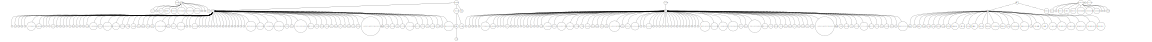

In [2]:
v.diagram(dpi='70')

In [23]:
state = generate_state_from_objects(datapath)['state']
v2 = vivarium_factory()


def flatten(d, parent_key='', sep='.'):
    items = {}
    for k, v in d.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k
        if isinstance(v, dict):
            items.update(flatten(v, new_key, sep=sep))
        else:
            items[new_key] = v
    return items

    
def add_objects(state, v):
    flattened = flatten(state)
    for obj_name, obj_value in flattened.items():
        print(obj_name)
        obj_path = []
        if '.' not in obj_name:
            obj_path.append(obj_name)
        else:
            obj_path = obj_name.split('.')
            obj_name = obj_path.pop(-1)
        v.add_object(name=obj_name, path=obj_path, value=obj_value)

In [24]:
v2

Vivarium( 
{'global_time': 0.0})

In [25]:
add_objects({'a': {'b': {'c': 11.11}}}, v2)

a.b.c


In [26]:
v2

Vivarium( 
{'a': {'b': {'c': {}}}, 'global_time': 0.0})